# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I am using a dataset provided by Dr. Saptarshi Ghosh and Soham Poddar from the Department of Computer Science and Engineering, IIT Kharagpur, India. 

## Install Dependencies

In [35]:
!pip install langdetect

## Import Packages

In [36]:
%matplotlib inline
import io
import re
import csv
import nltk
from nltk.stem import PorterStemmer
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import langdetect
from langdetect import DetectorFactory

import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
#from sklearn.utils.extmath import softmax
#from scipy.special import softmax

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Some Globals

In [37]:
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
DetectorFactory.seed = 0

## Upload dataset - Create dataframe

In [38]:
upload_train = files.upload()

Saving vs_train.csv to vs_train (8).csv


In [39]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev (8).csv


In [58]:
df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
df2 = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [59]:
print(df)

       Unnamed: 0                                              tweet  label
0               0  Sip N Shop Come thru right now #Marjais #Popul...      0
1               1  I don't know about you but My family and I wil...      1
2               2  @MSignorile Immunizations should be mandatory....      2
3               3  President Obama spoke in favor of vaccination ...      0
4               4  "@myfoxla: Arizona monitoring hundreds for mea...      0
...           ...                                                ...    ...
15971       15971  @Salon if u believe the anti-vax nutcases caus...      1
15972       15972  How do you feel about parents who don't #vacci...      0
15973       15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974       15974  Finance Minister: Budget offers room to procur...      0
15975       15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 3 columns]


In [60]:
print(df2)

      Unnamed: 0                                              tweet  label
0              0  @user They had a massive surge in with covid d...      1
1              1  Required vaccines for school: Parents and guar...      0
2              2  “@KCStar: Two more Johnson County children hav...      0
3              3  NV can do better. Which states are the best (a...      2
4              4  Nothing like killing ourselves w/ our own fear...      2
...          ...                                                ...    ...
2277        2277  RT @abc7: Number of measles cases reported in ...      0
2278        2278  Evidence points to the idea that "measles affe...      0
2279        2279  Where's @SavedYouAClick "@voxdotcom: Why you s...      2
2280        2280  Some of my favorite people have autism. If tha...      2
2281        2281  Coronavirus: The married couple behind the suc...      0

[2282 rows x 3 columns]


## Remove empty tweets

In [61]:
df.dropna(subset = ["tweet"], inplace=True)
df2.dropna(subset = ["tweet"], inplace=True)

df.drop_duplicates(subset = ["tweet"], inplace=True)
print(df.shape)
print(df2.shape)

(15881, 3)
(2282, 3)


## Check dataset balance



In [62]:
df.groupby("label")["tweet"].count()

label
0    7385
1    2070
2    6426
Name: tweet, dtype: int64

## Text Preprocessing

In [63]:
def clean_text(text):
  if text is None:
    return None
  if len(text) == 0:
    return None
    
  # remove tweets written in languages different from english
  try:
      lang = langdetect.detect(text)
  except:
      lang = 'Other'
  if lang != 'en':
    return None

  # remove special characters ,white spaces, urls
  text = text.lower()
  text = text.strip() 
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())
  text = re.sub(r'[^\w\s]','',text)
  text = re.sub(r'\_','',text)
  text = re.sub(r'http\S+', '', text)

  # perform stemming
  cleaned_text = ""
  for word in text.split() :
    temp = porter.stem(word)
    if word in stop_words:
      continue
    cleaned_text += (temp + " ")

  # tokenize
  #tokens = word_tokenize(cleaned_text)

  if cleaned_text is None:
    return None
  return cleaned_text


In [64]:
cleaned_text = []
for line in df["tweet"]:
  cleaned_text.append(clean_text(line))
cleaned_text_val = []
for line in df2["tweet"]:
  cleaned_text_val.append(clean_text(line))

## Create new column with clean text

In [65]:
df = df.assign(clean_tweet = lambda x: cleaned_text)
df2 = df2.assign(clean_tweet = lambda x: cleaned_text_val)

## Remove empty tweets again

In [66]:
df.dropna(subset = ["clean_tweet"], inplace=True)
df2.dropna(subset = ["clean_tweet"], inplace=True)

In [67]:
df

,Unnamed: 0,tweet,label,clean_tweet
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0,sip n shop come thru right marjai popularnobod...
1,1,I don't know about you but My family and I wil...,1,dont know famili take covid19 vaccin anytim soon
2,2,@MSignorile Immunizations should be mandatory....,2,immun mandatori period oklahoma wont let kid g...
3,3,President Obama spoke in favor of vaccination ...,0,presid obama spoke favor vaccin children fox s...
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0,arizona monitor hundr measl link disneyland sm...
...,...,...,...,...
15971,15971,@Salon if u believe the anti-vax nutcases caus...,1,u believ antivax nutcas caus measl u ignor oba...
15972,15972,How do you feel about parents who don't #vacci...,0,feel parent dont vaccin kid measlesoutbreak
15973,15973,70 Preschoolers Tested for Measles in Simi Val...,0,70 preschool test measl simi valley
15974,15974,Finance Minister: Budget offers room to procur...,0,financ minist budget offer room procur covid19...


In [68]:
df2

,Unnamed: 0,tweet,label,clean_tweet
0,0,@user They had a massive surge in with covid d...,1,massiv surg covid death immedi vaccin rollout ...
1,1,Required vaccines for school: Parents and guar...,0,requir vaccin school parent guardian children ...
2,2,“@KCStar: Two more Johnson County children hav...,0,two johnson counti children measl
3,3,NV can do better. Which states are the best (a...,2,nv better state best worst vaccin kid
4,4,Nothing like killing ourselves w/ our own fear...,2,noth like kill w fear mt milano vaccin fear fu...
...,...,...,...,...
2277,2277,RT @abc7: Number of measles cases reported in ...,0,rt number measl case report cali 10year high o...
2278,2278,"Evidence points to the idea that ""measles affe...",0,evid point idea measl affect immun system two ...
2279,2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2,where vaccin kid two minut
2280,2280,Some of my favorite people have autism. If tha...,2,favorit peopl autism that reason bring back di...


## Vectorize and Perform TF-IDF

### Training data

In [77]:
cv = CountVectorizer(stop_words='english')
word_count_vector_train = cv.fit_transform(df['clean_tweet'])
#word_count_vector_train.shape

(2227, 16334)

In [76]:
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True) 
tfidf_transformer.fit(word_count_vector_train)

# print idf values sorted by ascending order
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
vaccin,1.495976
measl,2.362114
kid,3.196966
immun,3.255596
health,3.331744
...,...
hostag,9.954480
hotb,9.954480
hotdog,9.954480
hopeless,9.954480


In [78]:
# count matrix 
count_vector_train = cv.transform(df['clean_tweet']) 

# tf-idf scores 
tf_idf_vector = tfidf_transformer.transform(count_vector_train)

In [79]:
feature_names = cv.get_feature_names() 
 
#get tf-idf vector for first tweet 
first_tweet_vector = tf_idf_vector[0] 
 
# print scores sorted by descending order
df3 = pd.DataFrame(first_tweet_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df3.sort_values(by=["tfidf"],ascending=False)

,tfidf
drdeath,0.386092
entireti,0.386092
immedi,0.319972
surg,0.298774
massiv,0.291364
...,...
fat,0.000000
fatal,0.000000
fate,0.000000
father,0.000000


### Test Data

In [88]:
word_count_vector_dev = cv.transform(df2['clean_tweet'])
count_vector_dev = cv.transform(df2['clean_tweet']) 
tf_idf_vector_dev = tfidf_transformer.transform(count_vector_dev)
first_document_vector_dev = tf_idf_vector_dev[0] 
df4 = pd.DataFrame(first_document_vector_dev.T.todense(), index=feature_names, columns=["tfidf"]) 
df4.sort_values(by=["tfidf"],ascending=False)

,tfidf
drdeath,0.386092
entireti,0.386092
immedi,0.319972
surg,0.298774
massiv,0.291364
...,...
fat,0.000000
fatal,0.000000
fate,0.000000
father,0.000000


## Perform Logistic Regression

In [97]:
tf_idf_vector
tf_idf_vector_dev
x_train = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector)
x_dev = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector_dev)
y_train = df["label"]
y_dev = df2["label"]
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16294,16295,16296,16297,16298,16299,16300,16301,16302,16303,16304,16305,16306,16307,16308,16309,16310,16311,16312,16313,16314,16315,16316,16317,16318,16319,16320,16321,16322,16323,16324,16325,16326,16327,16328,16329,16330,16331,16332,16333
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
LR = LogisticRegression(multi_class='multinomial', random_state = 0, max_iter = 1000)
LR.fit(x_train, y_train)

In [102]:
y_train_pred = LR.predict(x_train) #Return the predictions
LR.score(x_train, y_train)

0.8174244381296822

In [103]:
y_dev_pred = LR.predict(x_dev) #Return the predictions
LR.score(x_dev, y_dev)

0.7085765603951504

## Precision, Recall, F1 score

In [110]:
precision_recall_fscore_support(y_train, y_train_pred, average='weighted')

(0.8201461456653143, 0.8174244381296822, 0.8106766850021826, None)

In [111]:
precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted')

(0.7053765425590206, 0.7085765603951504, 0.7000159037392232, None)

In [124]:
accuracy_score(y_train, y_train_pred)

0.8174244381296822

In [125]:
accuracy_score(y_dev, y_dev_pred)

0.7085765603951504

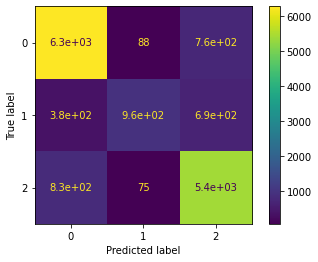

In [129]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [132]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))


              precision    recall  f1-score   support

     neutral       0.84      0.88      0.86      7125
    anti-vax       0.85      0.47      0.61      2032
     pro-vax       0.79      0.86      0.82      6327

    accuracy                           0.82     15484
   macro avg       0.83      0.74      0.76     15484
weighted avg       0.82      0.82      0.81     15484

              precision    recall  f1-score   support

     neutral       0.76      0.78      0.77      1029
    anti-vax       0.63      0.34      0.44       292
     pro-vax       0.67      0.75      0.70       906

    accuracy                           0.71      2227
   macro avg       0.69      0.62      0.64      2227
weighted avg       0.71      0.71      0.70      2227

